# Loan Default Prediction

In this scenario you are tasked with formulating a rule set to classify high-risk loan applicants (an applicant likely to fail to pay back a loan).  You are free to quantify what "high-risk" means and what types of rules are used.  The important thing is to _quantify the value of your rules_.

Therefore, an important part of our task is to quantify the effectiveness of the current practice (loan Grade and Subgrade).   Our conclusion should either propose changes that add value, or validate the current practice and show it is not practical to change it.   

This execise is inspired by the very recent release of Lending Club Loan Data from 2007-2015.  We will use it to build a Loan default predictor.  You can download the data here:

https://www.kaggle.com/wendykan/lending-club-loan-data

You can see the LendingClub website here:

https://www.lendingclub.com/

Check out "Browse Loans" to see how the business works.

I've left the code in this notebook as close as possible to my original first-pass, stream-of-conciousness analysis. 


In [62]:
import pandas
%matplotlib inline
# allows plotting in cells, we'll use later on.
import pylab
pylab.rcParams['figure.figsize'] = (10, 6) # set a larger figure size

Read the Excel data dictionary (it's nice to have it here).  You need to install the `xlrd` module first.  Windows: from the command prompt, go to your Anaconda python directory (you will see `python.exe` there) and:

`python -m pip install xlrd`  

Under Linux, from anywhere: `sudo -H python -m pip install xlrd`

In [63]:
import xlrd

In [64]:
df_dictionary = pandas.read_excel('C:/Users/peter/CM-ML-Class/4/LCDataDictionary.xlsx')

In [65]:
df_dictionary

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding m...
6,delinq_2yrs,The number of 30+ days past-due incidences of ...
7,desc,Loan description provided by the borrower
8,dti,A ratio calculated using the borrower’s total ...
9,dti_joint,A ratio calculated using the co-borrowers' tot...


In [66]:
df_dictionary.iloc[20].Description

u'The initial listing status of the loan. Possible values are \u2013 W, F'

In [67]:
import sqlite3
conn = sqlite3.connect('C:/Users/peter/CM-ML-Class/4/database.sqlite')

Find out the table name(s)

In [68]:
query = """
SELECT name FROM sqlite_master WHERE type='table'
"""
response = conn.execute(query)
response.fetchall()

[(u'loan',)]

Get an idea of the data formats

In [71]:
query = """
SELECT * FROM loan LIMIT 5
"""
df_sample = pandas.read_sql(query, conn)
with pandas.option_context('display.max_columns', 75):
    print df_sample

   index       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0      0  1077501  1296599.0     5000.0       5000.0           4975.0   
1      1  1077430  1314167.0     2500.0       2500.0           2500.0   
2      2  1077175  1313524.0     2400.0       2400.0           2400.0   
3      3  1076863  1277178.0    10000.0      10000.0          10000.0   
4      4  1075358  1311748.0     3000.0       3000.0           3000.0   

         term int_rate  installment grade sub_grade                 emp_title  \
0   36 months   10.65%       162.87     B        B2                      None   
1   60 months   15.27%        59.83     C        C4                     Ryder   
2   36 months   15.96%        84.33     C        C5                      None   
3   36 months   13.49%       339.31     C        C1       AIR RESOURCES BOARD   
4   60 months   12.69%        67.79     B        B5  University Medical Group   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0

In [72]:
df_sample

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
with pandas.option_context('display.max_rows', 75):
    print df_sample.iloc[0][:]

index                                                                          0
id                                                                       1077501
member_id                                                             1.2966e+06
loan_amnt                                                                   5000
funded_amnt                                                                 5000
funded_amnt_inv                                                             4975
term                                                                   36 months
int_rate                                                                  10.65%
installment                                                               162.87
grade                                                                          B
sub_grade                                                                     B2
emp_title                                                                   None
emp_length                  

In [74]:
df_sample.iloc[0].id

u'1077501'

In [75]:
query = """
SELECT * FROM loan WHERE id = '1077501'
"""
df_sample = pandas.read_sql(query, conn)
df_sample

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Is it one entry (id) for life of the loan?

In [76]:
query = """
SELECT id,COUNT(*) as count FROM loan GROUP BY id ORDER BY count DESC;
"""
df_count = pandas.read_sql(query, conn)
df_count.head()

,id,count
0,1000007,1
1,1000030,1
2,1000033,1
3,1000045,1
4,1000067,1


Our classifier will be used to rate loans before funding, so we have to be careful to pick fields that were known at loan origination for our classifer.  At this point, we would need to have a discussion with the IT folks about what fields would qualify.  Let's assume they said every field is from loan origination, except: 
   * totals such as total_pymnt, total_rec_late_fee, etc.
   * last and next payment dates, last credit pull date

# Data selection and cleaning

The full database is 492MB.  It will fit entirely in memory. No real need to subset using a SQL query.  I like to explicitly select out columns I'm thinking of using right now.  It helps organize my thought process. 

The database read, from disk, takes about a minute.

Note From The Future: I ran into some `Memory Error` problems on my 32-bit, 6GB linux box.  I solved these by restarting the kernel and re-running the notebook.


In [80]:
query = """
SELECT 
    id,
    member_id,
    funded_amnt_inv,
    funded_amnt,
    int_rate,
    installment,
    grade,
    sub_grade,
    emp_length,
    home_ownership,
    annual_inc,
    issue_d,
    loan_status,
    purpose,
    desc,
    dti,
    earliest_cr_line,
    inq_last_6mths,
    mths_since_last_delinq,
    open_acc,
    revol_bal,
    revol_util,
    total_acc,
    total_pymnt,
    total_rec_prncp,
    total_rec_int,
    total_rec_late_fee,
    application_type

FROM loan
"""

df = pandas.read_sql(query, conn)

In [77]:
df.describe()

,member_id,funded_amnt_inv,funded_amnt,installment,annual_inc,dti,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,issue_year
count,8.873820e+05,887382.000000,887382.000000,887382.000000,8.873780e+05,887382.00000,887353.000000,433069.000000,887353.000000,8.873820e+05,887353.000000,887382.000000,887382.000000,887382.000000,887382.000000,887383.000000
mean,3.500184e+07,14702.480039,14741.893147,436.717647,7.502761e+04,18.15702,0.694622,34.063697,11.548471,1.692076e+04,25.268032,7558.831876,5757.706058,1754.810042,0.396690,2014.019492
std,2.411336e+07,8442.107612,8429.898507,244.186619,6.469823e+04,17.19060,0.998447,21.884941,5.317310,2.242676e+04,11.840553,7871.238570,6625.433555,2095.368371,4.087818,2.481635
min,7.047300e+04,0.000000,500.000000,15.670000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.087713e+07,8000.000000,8000.000000,260.710000,4.500000e+04,11.91000,0.000000,15.000000,8.000000,6.443000e+03,17.000000,1914.590000,1200.570000,441.460000,0.000000,2013.000000
50%,3.709528e+07,13000.000000,13000.000000,382.550000,6.500000e+04,17.65000,0.000000,31.000000,11.000000,1.187500e+04,24.000000,4894.999559,3215.320000,1073.280000,0.000000,2014.000000
75%,5.847135e+07,20000.000000,20000.000000,572.600000,9.000000e+04,23.95000,1.000000,50.000000,14.000000,2.082900e+04,32.000000,10616.857115,8000.000000,2238.267500,0.000000,2015.000000
max,7.354484e+07,35000.000000,35000.000000,1445.460000,9.500000e+06,9999.00000,33.000000,188.000000,90.000000,2.904836e+06,169.000000,57777.579870,35000.030000,24205.620000,358.680000,2015.000000


In [78]:
df.head()

,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type,issue_datetime,issue_year
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599.0,4975.0,5000.0,10.65%,162.87,B,B2,10+ years,RENT,24000.0,...,13648.0,83.7%,9.0,5861.071414,5000.00,861.07,0.00,INDIVIDUAL,2011-12-01 00:00:00,2011
1077430,1314167.0,2500.0,2500.0,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,...,1687.0,9.4%,4.0,1008.710000,456.46,435.17,0.00,INDIVIDUAL,2011-12-01 00:00:00,2011
1077175,1313524.0,2400.0,2400.0,15.96%,84.33,C,C5,10+ years,RENT,12252.0,...,2956.0,98.5%,10.0,3003.653644,2400.00,603.65,0.00,INDIVIDUAL,2011-12-01 00:00:00,2011
1076863,1277178.0,10000.0,10000.0,13.49%,339.31,C,C1,10+ years,RENT,49200.0,...,5598.0,21%,37.0,12226.302212,10000.00,2209.33,16.97,INDIVIDUAL,2011-12-01 00:00:00,2011
1075358,1311748.0,3000.0,3000.0,12.69%,67.79,B,B5,1 year,RENT,80000.0,...,27783.0,53.9%,38.0,3242.170000,2233.10,1009.07,0.00,INDIVIDUAL,2011-12-01 00:00:00,2011


In [81]:
df.set_index('id', inplace=True)
df.head()

,member_id,funded_amnt_inv,funded_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,application_type
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599.0,4975.0,5000.0,10.65%,162.87,B,B2,10+ years,RENT,24000.0,...,NaN,3.0,13648.0,83.7%,9.0,5861.071414,5000.00,861.07,0.00,INDIVIDUAL
1077430,1314167.0,2500.0,2500.0,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,...,NaN,3.0,1687.0,9.4%,4.0,1008.710000,456.46,435.17,0.00,INDIVIDUAL
1077175,1313524.0,2400.0,2400.0,15.96%,84.33,C,C5,10+ years,RENT,12252.0,...,NaN,2.0,2956.0,98.5%,10.0,3003.653644,2400.00,603.65,0.00,INDIVIDUAL
1076863,1277178.0,10000.0,10000.0,13.49%,339.31,C,C1,10+ years,RENT,49200.0,...,35.0,10.0,5598.0,21%,37.0,12226.302212,10000.00,2209.33,16.97,INDIVIDUAL
1075358,1311748.0,3000.0,3000.0,12.69%,67.79,B,B5,1 year,RENT,80000.0,...,38.0,15.0,27783.0,53.9%,38.0,3242.170000,2233.10,1009.07,0.00,INDIVIDUAL


# Data characterization

Let's first think about value.  We want to focus on an area where we can make an impact.  Where's the money?  This is the most important part of our analysis.

In [82]:
g = df.groupby(['grade', 'sub_grade'])
type(g)

pandas.core.groupby.DataFrameGroupBy

In [86]:
g.describe()

member_id  funded_amnt_inv   funded_amnt  \
grade sub_grade                                                      
A     A1        count  2.291400e+04     22914.000000  22914.000000   
                mean   3.915953e+07     13713.163882  13719.049489   
                std    2.503006e+07      6640.221989   6638.770158   
                min    8.003900e+04         0.000000    725.000000   
                25%    1.359817e+07      8300.000000   8300.000000   
                50%    4.336746e+07     12000.000000  12000.000000   
                75%    6.298085e+07     19000.000000  19000.000000   
                max    7.351975e+07     29975.000000  29975.000000   
      A2        count  2.248500e+04     22485.000000  22485.000000   
                mean   3.660184e+07     13424.649528  13438.329998   
                std    2.433777e+07      7029.428535   7019.450000   
                min    7.069900e+04         0.000000   1000.000000   
                25%    1.103038e+07      8000.000000   8000.000000   
                50%    4.121855e+07     12000.000000  12000.000000   
                75%    5.916612e+07     19000.000000  19000.000000   
                max    7.351918e+07     34800.000000  34800.000000   
      A3        count  2.345700e+04     23457.000000  23457.000000   
                mean   3.402209e+07     13851.932788  13880.305453   
                std    2.452917e+07      7612.465151   7591.052749   
                min    7.068100e+04         0.000000    500.000000   
                25%    9.421393e+06      8000.000000   8000.000000   
                50%    3.587444e+07     12000.000000  12000.000000   
                75%    5.727550e+07     20000.000000  20000.000000   
                max    7.351958e+07     35000.000000  35000.000000   
      A4        count  3.453100e+04     34531.000000  34531.000000   
                mean   3.299618e+07     14081.951146  14110.883699   
                std    2.426575e+07      7802.406323   7786.866636   
                min    7.047300e+04         0.000000    500.000000   
                25%    9.658484e+06      8000.000000   8000.000000   
                50%    3.387013e+07     12000.000000  12000.000000   
...                             ...              ...           ...   
G     G2        std    2.330225e+07      8924.568099   8834.810800   
                min    9.760100e+04         0.000000    600.000000   
                25%    9.904551e+06     12700.000000  12881.250000   
                50%    2.850065e+07     19225.000000  19400.000000   
                75%    5.248941e+07     26887.500000  26937.500000   
                max    7.351590e+07     35000.000000  35000.000000   
      G3        count  9.810000e+02       981.000000    981.000000   
                mean   3.133463e+07     20659.371441  20817.609582   
                std    2.278509e+07      8736.871687   8570.579953   
                min    1.144660e+05        25.000000   1800.000000   
                25%    9.390211e+06     14175.000000  14400.000000   
                50%    2.725873e+07     19912.901304  20000.000000   
                75%    5.102594e+07     27800.000000  27800.000000   
                max    7.329644e+07     35000.000000  35000.000000   
      G4        count  6.630000e+02       663.000000    663.000000   
                mean   2.919028e+07     20709.930935  21186.123680   
                std    2.298516e+07      8984.334740   8535.060740   
                min    1.080730e+05         0.000000   1200.000000   
                25%    7.922062e+06     13050.000000  13712.500000   
                50%    2.629809e+07     20825.000000  21200.000000   
                75%    4.843774e+07     28000.000000  28000.000000   
                max    7.339605e+07     35000.000000  35000.000000   
      G5        count  5.760000e+02       576.000000    576.000000   
                mean   2.859729e+07     20566.414500  20954.861111   
                std    2.226776e+07 

In [87]:
x=g['total_rec_int'].sum()
type(x)

pandas.core.series.Series

In [88]:
x

grade  sub_grade
A      A1           1.288429e+07
       A2           1.483234e+07
       A3           1.925414e+07
       A4           3.093603e+07
       A5           4.354043e+07
B      B1           4.495163e+07
       B2           5.849451e+07
       B3           7.577072e+07
       B4           8.079421e+07
       B5           6.643680e+07
C      C1           7.938202e+07
       C2           8.565343e+07
       C3           8.923623e+07
       C4           9.232545e+07
       C5           8.649048e+07
D      D1           7.476157e+07
       D2           6.581057e+07
       D3           6.162788e+07
       D4           6.658288e+07
       D5           5.969734e+07
E      E1           5.157045e+07
       E2           5.209222e+07
       E3           4.467452e+07
       E4           4.049532e+07
       E5           3.454093e+07
F      F1           2.791445e+07
       F2           2.246921e+07
       F3           1.866930e+07
       F4           1.557349e+07
       F5           1.2410

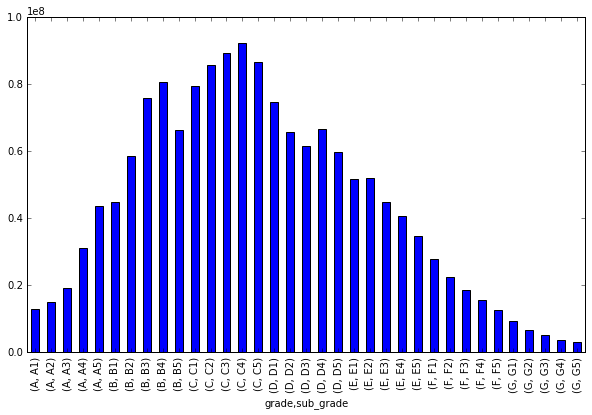

In [89]:
g['total_rec_int'].sum().plot(kind='bar')

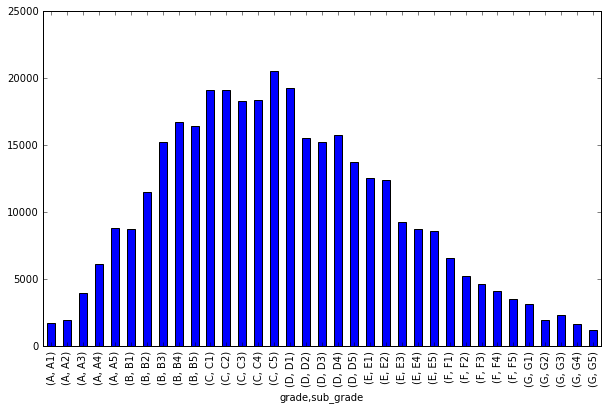

In [90]:
g['total_rec_late_fee'].sum().plot(kind='bar')

Most of the revenues are made from interest on the grade C loans. Not much money is made in late fees.  On the interest chart, there is an interesting sub-peak in B4-B5.  

Next we must realize that these are all data since 2007.  Has the money always been in C loans, or has that changed over time?

In [91]:
df.issue_d.unique()

array([u'Dec-2011', u'Nov-2011', u'Oct-2011', u'Sep-2011', u'Aug-2011',
       u'Jul-2011', u'Jun-2011', u'May-2011', u'Apr-2011', u'Mar-2011',
       u'Feb-2011', u'Jan-2011', u'Dec-2010', u'Nov-2010', u'Oct-2010',
       u'Sep-2010', u'Aug-2010', u'Jul-2010', u'Jun-2010', u'May-2010',
       u'Apr-2010', u'Mar-2010', u'Feb-2010', u'Jan-2010', u'Dec-2009',
       u'Nov-2009', u'Oct-2009', u'Sep-2009', u'Aug-2009', u'Jul-2009',
       u'Jun-2009', u'May-2009', u'Apr-2009', u'Mar-2009', u'Feb-2009',
       u'Jan-2009', u'Dec-2008', u'Nov-2008', u'Oct-2008', u'Sep-2008',
       u'Aug-2008', u'Jul-2008', u'Jun-2008', u'May-2008', u'Apr-2008',
       u'Mar-2008', u'Feb-2008', u'Jan-2008', u'Dec-2007', u'Nov-2007',
       u'Oct-2007', u'Sep-2007', u'Aug-2007', u'Jul-2007', u'Jun-2007',
       None, u'Dec-2013', u'Nov-2013', u'Oct-2013', u'Sep-2013',
       u'Aug-2013', u'Jul-2013', u'Jun-2013', u'May-2013', u'Apr-2013',
       u'Mar-2013', u'Feb-2013', u'Jan-2013', u'Dec-2012', u'Nov-2012',

Our loan issue dates are strings.  Best practice is to convert to a `date` or `datetime` type that Pandas understands.  To convert to a `datetime` from a string, see this reference: https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior

In [92]:
from datetime import datetime 
# slightly confusing; module and class have the same name
d = datetime.strptime("Dec-2011", "%b-%Y")
print d
print d.year

2011-12-01 00:00:00
2011


In [93]:
df['issue_datetime'] = df.issue_d.apply(
    lambda x: datetime.strptime(x, "%b-%Y") 
    if x is not None else datetime(1,1,1,0,0))

In [94]:
df['issue_year'] = df.issue_datetime.apply(lambda x: x.year)

In [95]:
df[['issue_d', 'issue_datetime', 'issue_year']].head()

,issue_d,issue_datetime,issue_year
id,,,
1077501,Dec-2011,2011-12-01 00:00:00,2011
1077430,Dec-2011,2011-12-01 00:00:00,2011
1077175,Dec-2011,2011-12-01 00:00:00,2011
1076863,Dec-2011,2011-12-01 00:00:00,2011
1075358,Dec-2011,2011-12-01 00:00:00,2011


In [96]:
g = df.groupby(['issue_year', 'grade'])

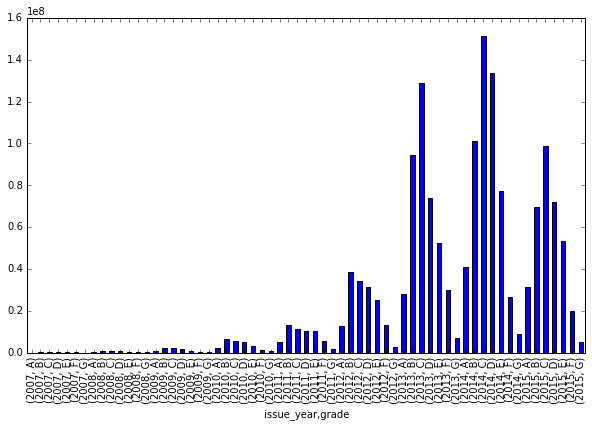

In [97]:
g['total_rec_int'].sum().plot(kind='bar')

In [98]:
g2 = g['total_rec_int'].sum()
g2.index


MultiIndex(levels=[[1, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], [u'A', u'B', u'C', u'D', u'E', u'F', u'G']],
           labels=[[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9], [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]],
           names=[u'issue_year', u'grade'])

In [99]:
type(g2)

pandas.core.series.Series

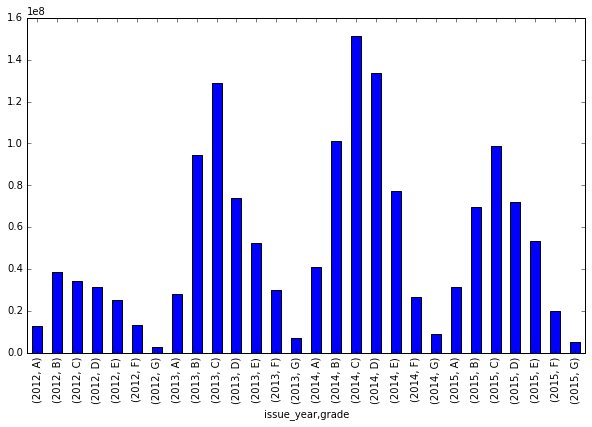

In [100]:
g2.loc[2012:2015].plot(kind='bar')

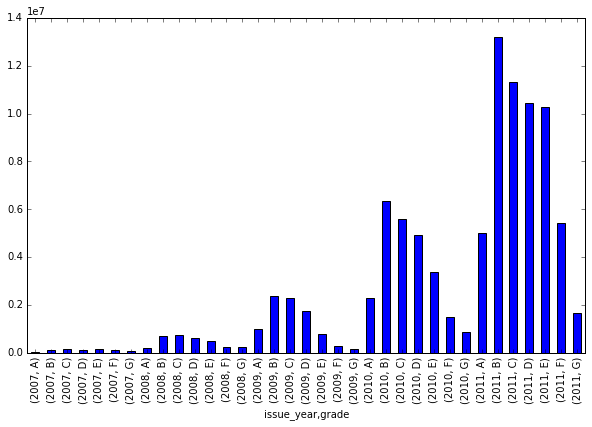

In [101]:
g2.loc[2007:2011].plot(kind='bar')

It appears there was a change in 2012-2013.  Since 2013, C-grade loans have generated the most interest revenue. There was also a dramatic increase in the overall business in 2013.  Models generally benefit from specificity.  Let's select out 2013-2015 C-grade loans for our first model.  In fact, let's use 2013-2014 to train our model and 2015 to test our model.

Note From the Future, in hindsight: also look at $'s lost to bad loans.

In [102]:
# conditions
c1 = df.issue_year >= 2013
c2 = df.issue_year <= 2014
c3 = df.grade == 'C'
c4 = df.issue_year == 2015

df_train = df.loc[c1 & c2 & c3]

df_test = df.loc[c3 & c4]

In [103]:
df_train[['grade', 'issue_datetime']].describe()

,grade,issue_datetime
count,104678,104678
unique,1,24
top,C,2014-10-01 00:00:00
freq,104678,11119


In [104]:
df_test[['grade', 'issue_datetime']].describe()

,grade,issue_datetime
count,120567,120567
unique,1,12
top,C,2015-10-01 00:00:00
freq,120567,13878


# Model build

# Prepare data for machine learning algorithms

I have decision trees in mind, which makes life easier.  We can mix numerical and categorical data.  We don't need to scale or normalize.  Decision trees divide the dataset according to rules such as "dti < 17.2" etc.  Decision trees are also very dependable and understandable.  I like to use them as a starting point whenever possible.

NOTE: FIRST PASS, LET'S INCLUDE ONLY NUMERICAL DATA AND DROP NAs DUE TO TIME CONSTRAINTS.  Categorical/cardinal data require some extra pre-processing.

In [107]:
import numpy as np

columns = [
        'funded_amnt', # num
        'installment', # num
        'annual_inc', # num
        'dti', # num
        'open_acc', # num
        'revol_bal', # num
        'inq_last_6mths', # num
        'mths_since_last_delinq', # num
        #'emp_length', # cardinal
        #'home_ownership', # categorical
        #'purpose' # categorical 
    ]

train_data = df_train[columns].copy()
train_data['loan_bigness'] = train_data.installment / (train_data.annual_inc / 12.0) # generates some inf
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data = train_data.dropna() # dropNA's eliminates about half the training data

test_data = df_test[columns].copy()
test_data['loan_bigness'] = test_data.installment / (test_data.annual_inc / 12.0)  
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data = test_data.dropna() # dropNA's eliminates about half the training data


train_target = df_train.ix[train_data.index]['loan_status']

test_target = df_test.ix[test_data.index]['loan_status']

In [108]:
train_data.head()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
id,,,,,,,,,
10224583,11100.0,384.68,90000.0,3.73,9.0,6619.0,0.0,16.0,0.051291
10109669,20000.0,683.36,80000.0,16.70,10.0,12948.0,1.0,8.0,0.102504
8617375,10000.0,232.58,25000.0,27.03,13.0,5394.0,0.0,63.0,0.111638
10099585,18450.0,630.40,65000.0,15.84,14.0,20803.0,0.0,35.0,0.116382
10109703,8325.0,291.09,65000.0,5.71,5.0,6363.0,0.0,8.0,0.053740


In [109]:
test_data.head()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
id,,,,,,,,,
68444620,35000.0,778.38,128000.0,6.46,17.0,14277.0,0.0,46.0,0.072973
67849662,4225.0,146.16,35000.0,15.22,6.0,1058.0,0.0,18.0,0.050112
68407277,3600.0,123.03,55000.0,5.91,7.0,2765.0,1.0,30.0,0.026843
68585839,17475.0,597.17,39750.0,23.58,7.0,10987.0,0.0,27.0,0.180278
68009401,16000.0,379.39,48000.0,33.18,11.0,19108.0,0.0,33.0,0.094848


In [110]:
test_target.head()

id
68444620    Issued
67849662    Issued
68407277    Issued
68585839    Issued
68009401    Issued
Name: loan_status, dtype: object

In [36]:
test_data.loan_bigness.describe()

count    64381.000000
mean         0.074722
std          0.038921
min          0.000123
25%          0.045745
50%          0.068768
75%          0.097619
max          0.351836
Name: loan_bigness, dtype: float64

In [37]:
train_data.describe()

,funded_amnt,installment,annual_inc,dti,open_acc,revol_bal,inq_last_6mths,mths_since_last_delinq,loan_bigness
count,52376.000000,52376.000000,5.237600e+04,52376.000000,52376.000000,52376.000000,52376.000000,52376.000000,52376.000000
mean,14296.895047,428.505704,7.492756e+04,17.788436,11.597850,14453.553441,0.822400,33.425577,0.077184
std,8253.994314,247.165717,4.910161e+04,7.824336,5.007962,17298.178764,1.052674,21.745917,0.039057
min,1000.000000,33.410000,8.000000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.001711
25%,8000.000000,261.540000,4.700000e+04,11.930000,8.000000,5786.000000,0.000000,15.000000,0.047827
50%,12000.000000,363.970000,6.500000e+04,17.340000,11.000000,10389.500000,1.000000,30.000000,0.071356
75%,20000.000000,538.150000,9.000000e+04,23.392500,14.000000,18019.000000,1.000000,49.000000,0.101353
max,35000.000000,1252.560000,2.000000e+06,39.990000,84.000000,722995.000000,6.000000,188.000000,0.207965


In [111]:
train_target.unique()

array([u'Current', u'Fully Paid', u'Charged Off', u'Late (31-120 days)',
       u'Late (16-30 days)', u'In Grace Period', u'Default'], dtype=object)

In [113]:
train_target

id
10224583        Current
10109669     Fully Paid
8617375     Charged Off
10099585        Current
10109703        Current
10117493        Current
10159475        Current
10119428        Current
10099426        Current
10139417        Current
10149363        Current
10099550     Fully Paid
10129392     Fully Paid
10159220     Fully Paid
10139564        Current
10139578     Fully Paid
10089380     Fully Paid
10089464    Charged Off
10078664     Fully Paid
10139518        Current
10169371     Fully Paid
10149257        Current
10149220     Fully Paid
10159109    Charged Off
10129206        Current
10109260        Current
10119291     Fully Paid
10129204     Fully Paid
10109439        Current
10139385     Fully Paid
               ...     
10136316        Current
10066251     Fully Paid
9645048      Fully Paid
10166166     Fully Paid
10176152        Current
10176216     Fully Paid
10126135        Current
10076101    Charged Off
10135985     Fully Paid
10075958        Current
10095477     

In [112]:
pandas.Series([1,1,1,2,2,2,3,3,2,2,2,2,1,5]).unique()

array([1, 2, 3, 5], dtype=int64)

In [39]:
def map_status(status):
    label = 1 if status in ('Current', 'Fully Paid', 'In Grace Period') else 0
    return label

In [114]:
train_target = df_train.ix[train_data.index]['loan_status'].apply(map_status)
test_target = df_test.ix[test_data.index]['loan_status'].apply(map_status)

In [115]:
train_target.describe() # looks like 10% bad loans

count    52376.000000
mean         0.901062
std          0.298582
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: loan_status, dtype: float64

In [116]:
test_target.describe() # interesting, looks like 4% bad loans

count    64381.000000
mean         0.959957
std          0.196061
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: loan_status, dtype: float64

We have a low percentage of bad loans.  Keep this in mind when we evaluate our classifier.  If we just say, "all grade C loans are good", we will be 96% accurate.  

In [117]:
train_target.index[0:5], train_data.index[0:5] # just checking :)

(Index([u'10224583', u'10109669', u'8617375', u'10099585', u'10109703'], dtype='object', name=u'id'),
 Index([u'10224583', u'10109669', u'8617375', u'10099585', u'10109703'], dtype='object', name=u'id'))

In [118]:
test_target.index[0:5], test_data.index[0:5]

(Index([u'68444620', u'67849662', u'68407277', u'68585839', u'68009401'], dtype='object', name=u'id'),
 Index([u'68444620', u'67849662', u'68407277', u'68585839', u'68009401'], dtype='object', name=u'id'))

In [119]:
print df_train.emp_length.unique()
print df_train.home_ownership.unique()
print df_train.purpose.unique()

[u'1 year' u'3 years' u'10+ years' u'5 years' u'2 years' u'4 years' u'n/a'
 u'6 years' u'7 years' u'< 1 year' u'9 years' u'8 years']
[u'RENT' u'MORTGAGE' u'OWN']
[u'debt_consolidation' u'other' u'major_purchase' u'credit_card'
 u'home_improvement' u'medical' u'car' u'vacation' u'small_business'
 u'moving' u'house' u'wedding' u'renewable_energy']


## Feature Selection

A subject-matter expert (SME) is usually the best feature selector.  Automated feature selection is also important.  Automated selection is best used to validate and/or enhance the SME's advice.  Scikit learn has a variety of feature selectors.  We will try a few here.  Reference:

http://scikit-learn.org/stable/modules/feature_selection.html


### ExtraTreesClassifier

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier



In [121]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier

In [122]:
forest = ExtraTreesClassifier(n_estimators=100)
forest.fit(train_data, train_target)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Following was adapted to our problem from this example:
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py

In [123]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [124]:
indices

array([3, 5, 8, 7, 1, 2, 4, 0, 6], dtype=int64)

In [125]:
train_data.columns[indices]  # names

Index([u'dti', u'revol_bal', u'loan_bigness', u'mths_since_last_delinq',
       u'installment', u'annual_inc', u'open_acc', u'funded_amnt',
       u'inq_last_6mths'],
      dtype='object')

In [126]:
# Print the feature ranking
print("Feature ranking:")

for f in range(train_data.shape[1]):
    print("%d. %s (%f)" % (f + 1, train_data.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. dti (0.128925)
2. revol_bal (0.128468)
3. loan_bigness (0.126872)
4. mths_since_last_delinq (0.125828)
5. installment (0.120432)
6. annual_inc (0.114263)
7. open_acc (0.113988)
8. funded_amnt (0.102928)
9. inq_last_6mths (0.038296)


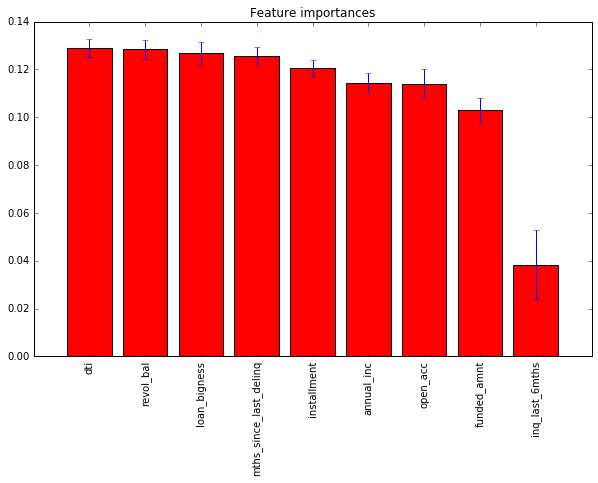

In [127]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_data.shape[1]), train_data.columns[indices], rotation=90)
plt.xlim([-1, train_data.shape[1]])
plt.show()

let's go with `dti`, `revol_bal`, `loan_bigness`, and `mths_since_last_delinq` for our initial model

In [128]:
model_features=['dti', 'revol_bal', 'loan_bigness', 'mths_since_last_delinq']

train_data = train_data[model_features].copy()
test_data = test_data[model_features].copy()

train_data.head()

,dti,revol_bal,loan_bigness,mths_since_last_delinq
id,,,,
10224583,3.73,6619.0,0.051291,16.0
10109669,16.70,12948.0,0.102504,8.0
8617375,27.03,5394.0,0.111638,63.0
10099585,15.84,20803.0,0.116382,35.0
10109703,5.71,6363.0,0.053740,8.0


## Train the Model
It's rather anti-climatic.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
rf = RandomForestClassifier(n_estimators=101)

In [131]:
rf.fit(train_data, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=101, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Use the model to classify our test (future) data

In [132]:
test_data.describe()

,dti,revol_bal,loan_bigness,mths_since_last_delinq
count,64381.000000,64381.00000,64381.000000,64381.000000
mean,19.273488,15288.83871,0.074722,33.583744
std,8.581110,20947.50662,0.038921,22.105244
min,0.000000,0.00000,0.000123,0.000000
25%,12.840000,5632.00000,0.045745,15.000000
50%,18.750000,10520.00000,0.068768,30.000000
75%,25.380000,18663.00000,0.097619,50.000000
max,104.000000,921464.00000,0.351836,149.000000


In [133]:
probs = rf.predict_proba(test_data)
probs

array([[ 0.07920792,  0.92079208],
       [ 0.13861386,  0.86138614],
       [ 0.01980198,  0.98019802],
       ..., 
       [ 0.12871287,  0.87128713],
       [ 0.10891089,  0.89108911],
       [ 0.0990099 ,  0.9009901 ]])

# Model evaluation
Receiver operating characteristic curves are almost always the best way to evaluate classifiers.

Justification: http://www.hpl.hp.com/techreports/2003/HPL-2003-4.pdf

I encourage you to test and explore the conslusions of that paper.
I feel there are too many bad examples of model evaluation online.  The paper will get you going in the right direction.

Let's see what the ROC curve says about our classifier.  We'll also check out AUC (**A**rea **U**nder the roc **C**urve), a related metric.

In [134]:
from sklearn.metrics import roc_curve, auc

In [135]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(test_target, probs[:, 1])
roc_auc = auc(fpr, tpr)
print roc_auc


0.521496332217


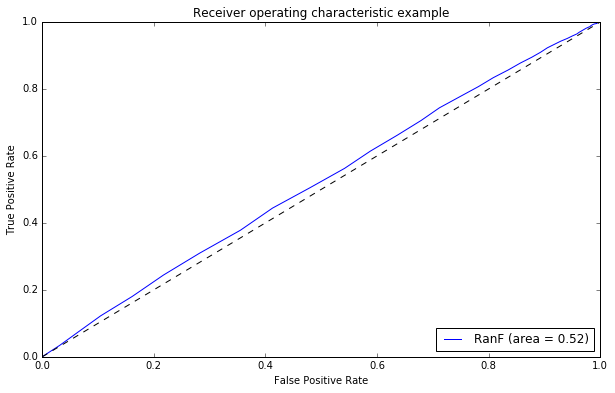

In [136]:
# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='RanF (area = %0.2f)' % roc_auc)
#pl.plot(fpr1, tpr1, label='SVC (area = %0.2f)' % roc_auc1)
#pl.plot(fpr2, tpr2, label='KNN(3) (area = %0.2f)' % roc_auc2)
#pl.plot(fpr3, tpr3, label='KNN(21) (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Just to drive the point home about using ROC curves and AUC instead of the built-in accuracy metric:

In [137]:
rf.score(test_data, test_target)

0.95946008915673875

# Conclusion

Current status: our first-draft model has very little predictive power.  It's time to go back provide more, better, or different input data.  It's probably a lost cause to try different algorithms for a model with an AUC of 0.52.   